In [1]:
# set up paths
from os import pardir, getcwd
from os.path import join, abspath
import sys
nb_dir = getcwd()
project_path = abspath(join(nb_dir, pardir))
sys.path.append(project_path)
# 3rd party imports
import matplotlib.pyplot as plt
from tqdm import tqdm
# ux imports
from ux.calcs.transitions import transition_counts, transition_probabilities
from ux.plots.transitions import plot_transition_matrix
# local imports
from pmi_examples.helpers import create_card_view_task
from managers.card_view_manager import CardViewManager
from paths.files import FN_INTERIM_CARD_VIEW
from constants import TOPICS, TOPIC_ABBREVIATIONS

## Transition Matrices

### Transition Counts

Visualizing Users' paths through an app is typically done using a Sankey diagram, but this can quickly become unwieldy when there are many diifferent locations a User could be in. One alternative method is a Transition Matrix showing the counts of users who went from each Location to each other.

Let's get started in the usual way, by creating a new DatabaseManager, defining a Task of interest and iterating through Sessions to get Action Sequences.

In [2]:
# set up db manager
db = CardViewManager(data=FN_INTERIM_CARD_VIEW)
# create task
task = create_card_view_task(
    db=db, search_text='critical-pm-relationships',
    task_name='Critical PM Relationships'
)
# get sequences from each session
sessions = db.sessions()
sequences = [
    db.get_session_sequence(session_id=session.session_id)
    for session in tqdm(sessions, 'Reading session sequences')
]

Reading session sequences: 100%|██████████| 1191/1191 [00:10<00:00, 118.08it/s]


Now we have the sequences, we can use the `ux` library's `transition_counts` method to count the transitions in a single shot.

In [3]:
counts = transition_counts(
    task=task, action_sequences=sequences
)

This method returns a dictionary, where each keys is a tuple containing the source and destination locations, and each value is the associated number of times this transition occurred.

In [4]:
counts

defaultdict(int,
            {(ActionTemplate(card-view: /topic/critical-pm-relationships/0/0),
              ActionTemplate(card-view: /topic/critical-pm-relationships/0/0)): 12,
             (ActionTemplate(card-view: /topic/critical-pm-relationships/0/0),
              ActionTemplate(card-view: /topic/critical-pm-relationships/0/1)): 60,
             (ActionTemplate(card-view: /topic/critical-pm-relationships/0/1),
              ActionTemplate(card-view: /topic/critical-pm-relationships/1/2)): 51,
             (ActionTemplate(card-view: /topic/critical-pm-relationships/1/2),
              ActionTemplate(card-view: /topic/critical-pm-relationships/1/4)): 56,
             (ActionTemplate(card-view: /topic/critical-pm-relationships/1/4),
              ActionTemplate(card-view: /topic/critical-pm-relationships/1/5)): 70,
             (ActionTemplate(card-view: /topic/critical-pm-relationships/1/5),
              ActionTemplate(card-view: /topic/critical-pm-relationships/1/6)): 62,
     

To visualize this more clearly, we can use the `ux` library's `plot_transition_matrix` method. First let's write a function to extract short names from the ActionTemplates so that the plot is more legible:

In [5]:
def abbreviate_slug(slug: str):
    """
    Map a slug name to its abbreviation for plotting.
    """
    _, _, topic_name, lesson_number, card_number = slug.split('/')
    topic_abbreviation = TOPIC_ABBREVIATIONS[topic_name]
    return '{}|{}|{}'.format(
        topic_abbreviation, str(int(lesson_number)).zfill(2), str(int(card_number)).zfill(2)
    )

And now, define some values for the seaborn heatmap that will be used to plot the data:

In [6]:
heatmap_kws = {
    'annot': True,
    'linewidths': 0.5,
    'linecolor': '#cccccc',
    'annot_kws': {'size': 6}
}

And now generate the plot:

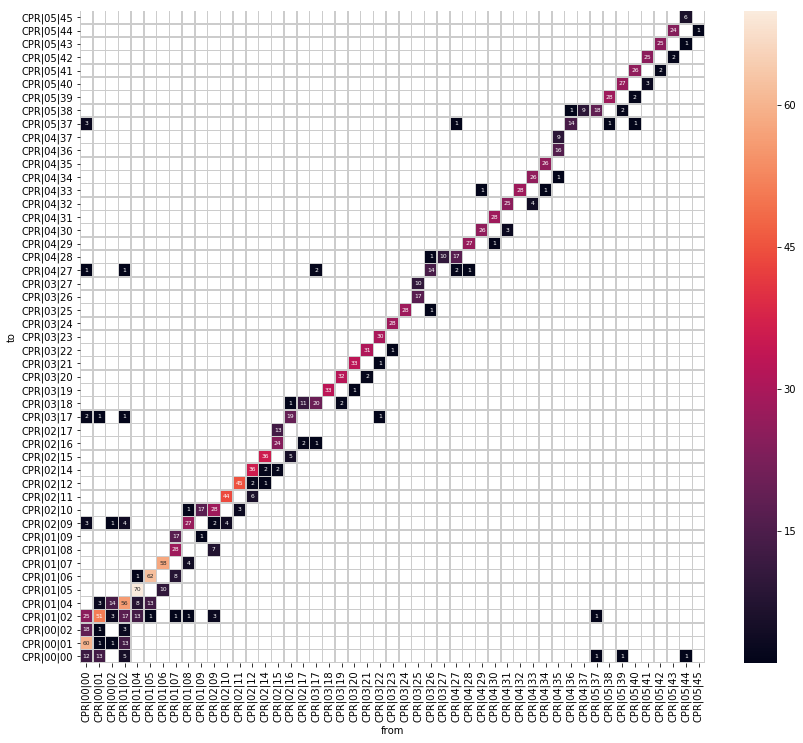

In [7]:
fig_counts, ax_counts = plt.subplots(figsize=(14, 12))
heatmap_kws['fmt'] = '0.0f'
plot_transition_matrix(
    transitions=counts,
    get_name=lambda action: abbreviate_slug(action.source_id),
    ax=ax_counts,
    heatmap_kws=heatmap_kws
)

Given that the design intent is that Users should navigate forwards to the next card, and maybe sometimes backwards to the previous card, this plot shows us that there are circumstances where users jump far ahead or backwards, pointing to a potential usability issue.

We can also see that there is a fairly significant drop-off rate after `CPR|01|06`, potentially indicating that people are giving up at this point. We can find out by asking real-life Users.

### Transition Probabilities

Calculating transition probabilities is very similar to transition counts, except that each source => destination pair is normalized to the number of times the source location appears as a source. We can think of this as the conditional probability of a User moving to destination location `D` given that they are at source location `S`.

Start by calculating the transition probabilities using `ux`:

In [8]:
probs = transition_probabilities(
    task=task, action_sequences=sequences
)

In [9]:
probs

{(ActionTemplate(card-view: /topic/critical-pm-relationships/0/0),
  ActionTemplate(card-view: /topic/critical-pm-relationships/0/0)): 0.0967741935483871,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/0/0),
  ActionTemplate(card-view: /topic/critical-pm-relationships/0/1)): 0.4838709677419355,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/0/1),
  ActionTemplate(card-view: /topic/critical-pm-relationships/1/2)): 0.7285714285714285,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/1/2),
  ActionTemplate(card-view: /topic/critical-pm-relationships/1/4)): 0.56,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/1/4),
  ActionTemplate(card-view: /topic/critical-pm-relationships/1/5)): 0.7608695652173914,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/1/5),
  ActionTemplate(card-view: /topic/critical-pm-relationships/1/6)): 0.8157894736842105,
 (ActionTemplate(card-view: /topic/critical-pm-relationships/1/6),
  ActionTemplate(

Now modify the heatmap numeric display precision, since we are now dealing with floats not ints

In [10]:
heatmap_kws['fmt'] = '.2f'

And plot the result on new axes, using the same method as before.

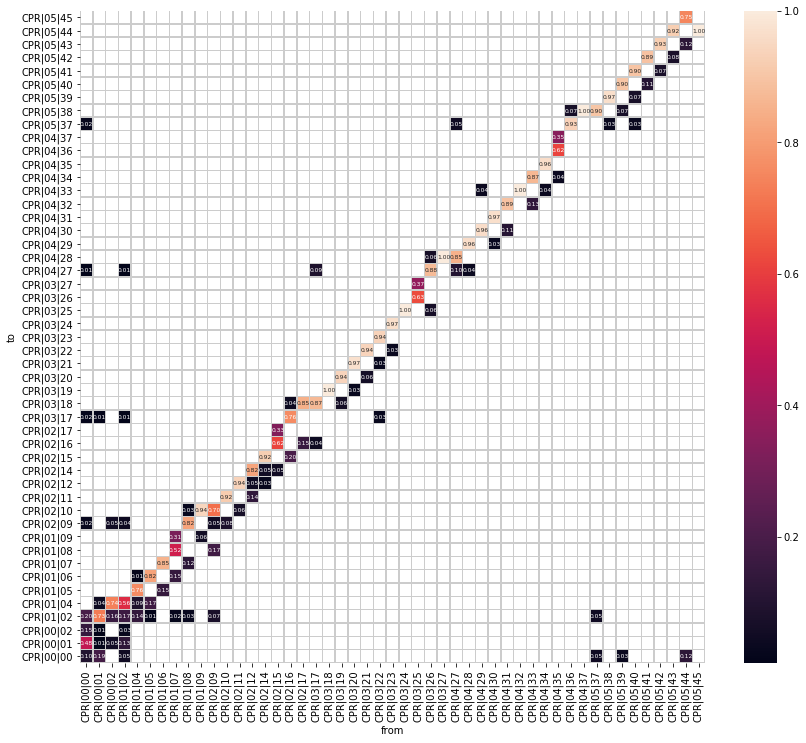

In [11]:
fig_probs, ax_probs = plt.subplots(figsize=(14, 12))
plot_transition_matrix(
    transitions=probs,
    get_name=lambda action: abbreviate_slug(action.source_id),
    ax=ax_probs,
    heatmap_kws=heatmap_kws
)

This normalized view helps to show more clearly where the individual usability issues might be located. For example, Users at location `CPR|03|25` are moving ahead one card to `CPR|03|26` only about 63% of the time compared to the usual 80%-100%. Further investigation would be needed to explain the reasons for this anomalous behavior.